## G-CARE Benchmark

In [1]:
using Graphs: DiGraph
using StatsPlots
include("Source/datasets.jl")
include("Source/QuasiStableCardinalityEstimator.jl")

get_cardinality_bounds (generic function with 1 method)

In [2]:
aids_data_file_path = "dataset/aids/aids.txt"
human_data_file_path = "dataset/human/human.txt"
lubm80_data_file_path = "dataset/lubm80/lubm80.txt"
yago_data_file_path = "dataset/yago/yago.txt"

human_data = load_dataset(human_data_file_path)
aids_data = load_dataset(aids_data_file_path)
lubm80_data = load_dataset(lubm80_data_file_path)
#yago_data = load_dataset(yago_data_file_path)
nothing

In [9]:
#datasets = [aids_data, human_data, lubm80_data, yago_data]
#dataset_names = ["aids", "human", "lubm80", "yago"]
datasets = Dict("aids"=>aids_data, "human"=>human_data, "lubm80"=>lubm80_data)
dataset_names = ["aids", "human"]
num_sample_nodes = Dict("aids"=>10000, "human"=>100, "lubm80"=>10)
max_cycle_size = Dict("aids"=>6, "human"=>3, "lubm80" => -1)

Dict{String, Int64} with 3 entries:
  "aids"   => 6
  "human"  => 3
  "lubm80" => -1

In [10]:
build_time = Dict()
summary_size = Dict()
color_summaries = Dict()
for dataset in dataset_names
    results = @timed generate_color_summary(datasets[dataset], 32, verbose=true, max_size = max_cycle_size[dataset], num_sample_nodes=num_sample_nodes[dataset])
    build_time[dataset] = results[2]
    summary_size[dataset] = get_color_summary_size(results[1])
    color_summaries[dataset] = results[1]
end

In [10]:
include("Source/QuasiStableCardinalityEstimator.jl")

human_query_directories = ["/queryset/human/Chain_3/",
"/queryset/human/Graph_3/",
"/queryset/human/Star_3/",
"/queryset/human/Tree_3/",
                    ]
human_query_paths = [readdir(pwd() * dir, join=true) for dir in human_query_directories]
human_query_paths = [(human_query_paths...)...]
human_exact_sizes = []
human_bounds = []
human_bounds_with_stats = []
human_relative_errors = []
human_relative_errors_with_stats = []
human_query_type = []
println("Summary Size: ", summary_size["human"])
println("Summary Build Time: ", build_time["human"])
for query_path in human_query_paths
    println("Query: ", query_path)
    id_and_query = load_query(query_path)
    id = id_and_query[1]
    query = id_and_query[2]
    bound_results = @timed get_cardinality_bounds(query, color_summaries["human"], usingStoredStats=false)
    bound_results_with_stats = @timed get_cardinality_bounds(query, color_summaries["human"], usingStoredStats=true)
    exact_size_results = @timed get_exact_size(query, datasets["human"])
    gcare_size = load_true_cardinality(replace(query_path, "queryset"=>"TrueCardinalities"))
    query_type = match(r"/queryset/human/(.*)_./.*", query_path).captures[1]
#    println("Bound Time: ", bound_results[2])
#    println("Exact Size Time: ", exact_size_results[2])
#    println("Exact Size: ", exact_size_results[1])
#    println("GCare Exact Size: ", gcare_size)
    if gcare_size != exact_size_results[1]
        println("Bad Exact Size Estimate!!")
        break
    end
#    println("Bound [Lower, Avg, Upper]: ", bound_results[1])
#    println("Relative Error [Lower, Avg, Upper]: ", bound_results[1]./exact_size_results[1])
    bound_results[1][2] = max(1, bound_results[1][2])
    bound_results_with_stats[1][2] = max(1, bound_results_with_stats[1][2])
    push!(human_exact_sizes, gcare_size)
    push!(human_bounds, bound_results[1])
    push!(human_bounds_with_stats, bound_results_with_stats[1])
    push!(human_relative_errors, bound_results[1] ./ gcare_size)
    push!(human_relative_errors_with_stats, bound_results_with_stats[1] ./ gcare_size)
    push!(human_query_type, query_type)
end

Summary Size: nothing
Summary Build Time: 11.580982934


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Chain_3/uf_Q_1_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/human/Chain_3/uf_Q_1_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Chain_3/uf_Q_1_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_0_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_0_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_0_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_0_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_0_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_1_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_1_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_1_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_1_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_2_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_2_2.txt
Query: /home/kylebd99/C

Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_3_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_3_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_3_5.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_3_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_3_7.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_3_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Graph_3/uf_Q_3_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_0_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_1_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_1_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_1_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_1_4.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_1_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_1_6.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_2_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_2_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Star_3/uf_Q_2_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_0_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_0_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_0_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_1_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_2_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_2_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_2_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_2_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_3_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/human/Tree_3/uf_Q_3_2.txt


In [11]:
using Statistics
println(maximum([log10(x[2]) for x in human_relative_errors]))
println(mean([abs(log10(x[2])) for x in human_relative_errors]))
println(minimum([log10(x[2]) for x in human_relative_errors]))

2.1162174132207614
0.6191122725795751


-1.5314789170422551


In [12]:
using Statistics
println(maximum([log10(x[2]) for x in human_relative_errors_with_stats]))
println(mean([abs(log10(x[2])) for x in human_relative_errors_with_stats]))
println(minimum([log10(x[2]) for x in human_relative_errors_with_stats]))

2.1162174132207614


0.6191122725795751
-1.5314789170422551


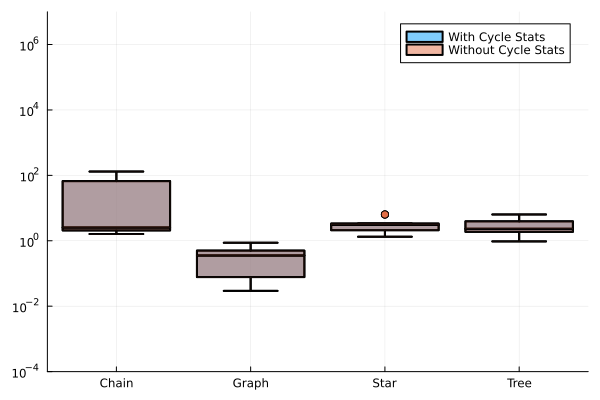

In [38]:
StatsPlots.boxplot(human_query_type, [x[2] for x in human_relative_errors_with_stats],  yscale=:log10, fillalpha=0.5, linewidth=2, label="With Cycle Stats", ylims=[10^-4, 10^7], yticks=[10^-4,10^-2, 1, 10^2, 10^4, 10^6])
StatsPlots.boxplot!(human_query_type, [x[2] for x in human_relative_errors],  yscale=:log10, fillalpha=0.5, linewidth=2, label="Without Cycle Stats")

In [13]:
include("Source/QuasiStableCardinalityEstimator.jl")

aids_query_directories = ["/queryset/aids/Chain_3/",
"/queryset/aids/Chain_6/",
"/queryset/aids/Chain_9/",
"/queryset/aids/Chain_12/",
"/queryset/aids/Cycle_3/",
"/queryset/aids/Cycle_6/",
"/queryset/aids/Flower_6/",
"/queryset/aids/Flower_9/",
"/queryset/aids/Flower_12/",
"/queryset/aids/Graph_3/",
"/queryset/aids/Graph_6/",
"/queryset/aids/Graph_9/",
"/queryset/aids/Graph_12/",
"/queryset/aids/Petal_6/",
"/queryset/aids/Petal_9/",
"/queryset/aids/Petal_12/",
"/queryset/aids/Star_3/",
"/queryset/aids/Star_6/",
"/queryset/aids/Star_9/",
"/queryset/aids/Tree_3/",
"/queryset/aids/Tree_6/",
"/queryset/aids/Tree_9/",
"/queryset/aids/Tree_12/"]
aids_query_paths = [readdir(pwd() * dir, join=true) for dir in aids_query_directories]
aids_query_paths = [(aids_query_paths...)...]
aids_exact_sizes = []
aids_bounds = []
aids_bounds_with_stats = []
aids_relative_errors = []
aids_relative_errors_with_stats = []
aids_query_types = []
println("Summary Size: ", summary_size["aids"])
println("Summary Build Time: ", build_time["aids"])
for query_path in aids_query_paths
    println("Query: ", query_path)
    id_and_query = load_query(query_path)
    id = id_and_query[1]
    query = id_and_query[2]
    query_type = match(r".*/queryset/aids/(.*)_.*/.*", query_path).captures[1]
    bound_results = @timed get_cardinality_bounds(query, color_summaries["aids"], usingStoredStats=false)
    bound_results_with_stats = @timed get_cardinality_bounds(query, color_summaries["aids"], usingStoredStats=true)
    gcare_size = load_true_cardinality(replace(query_path, "queryset"=>"TrueCardinalities"))
#    println("Bound Time: ", bound_results[2])
#    println("Exact Size: ", gcare_size)
#    println("Bound [Lower, Avg, Upper]: ", bound_results[1])
#    println("Relative Error [Lower, Avg, Upper]: ", bound_results[1]./gcare_size)
    bound_results[1][2] = max(1, bound_results[1][2])
    bound_results_with_stats[1][2] = max(1, bound_results_with_stats[1][2])
    push!(aids_exact_sizes, gcare_size)
    push!(aids_bounds, bound_results[1])
    push!(aids_bounds_with_stats, bound_results_with_stats[1])
    push!(aids_relative_errors, bound_results[1] ./ gcare_size)
    push!(aids_relative_errors_with_stats, bound_results_with_stats[1] ./ gcare_size)
    push!(aids_query_types, query_type)
end

Summary Size: nothing
Summary Build Time: 94.84607166


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_0_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_1_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_1_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_1_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_1_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_1_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_2_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_2_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_2_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_2_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_2_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_2_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_3/uf_Q_2_15.txt
Query: /home/kylebd99/Cardina

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_3_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_4_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_4_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_4_11.txt
Query: /home/kylebd99/Cardinalit

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_17.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_18.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_19.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_20.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_6/uf_Q_5_9.txt
Query: /home/kylebd99/Cardinali

Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_3_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_3_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_4_5.txt
Query: /home/kylebd99/C

Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_19.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_9/uf_Q_5_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_3_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_3_3.txt
Query: /home/kylebd99/Ca

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_4_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_4_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_4_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_4_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_4_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_4_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Chain_12/uf_Q_5_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_1_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_1_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_1_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_1_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_1_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_1_7.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_1_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_1_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_11.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_15.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_16.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_17.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_6.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_8.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_2_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_10.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_12.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_14.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_15.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_16.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_17.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_18.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_19.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_20.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_5.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_7.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_3/uf_Q_3_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_1_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_1_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_1_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_1_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_2_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_2_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_2_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_3_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Cycle_6/uf_Q_3_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_0_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_1_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_1_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_1_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_1_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_2_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_2_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_2_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_2_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_2_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_2_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_2_7.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_10.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_12.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_14.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_15.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_16.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_6.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_8.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_3_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_4_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_4_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_4_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_4_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_4_5.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_4_6.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_5_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_5_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_5_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_5_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_6/uf_Q_5_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_1_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_2_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_2_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_2_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_6.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_3_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_12.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_4_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_10.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_11.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_4.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_5.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_6.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_7.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_8.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_9/uf_Q_5_9.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_3_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_4_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_4_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_4_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_4_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_4_5.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_4_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_4_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_6.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_7.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_8.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Flower_12/uf_Q_5_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_0_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_16.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_17.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_18.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_19.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_1_2.txt
Query: /home/kylebd9

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_3_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_3_5.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_3_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_3_8.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_3_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_4_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_4_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_4_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_4_17.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_4_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_4_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_3/uf_Q_5_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_1_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_3_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinalit

Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_4_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_4_18.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_4_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_4_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_4_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_5_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_5_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_5_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_5_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_6/uf_Q_5_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_9/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_9/uf_Q_0_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_9/uf_Q_1_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Graph_12/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_4.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_6.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_7.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_8.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_2_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_10.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_11.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_13.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_5.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_7.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_8.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_3_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_10.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_11.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_12.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_13.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_14.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_15.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_16.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_17.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_18.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_19.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_20.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_5.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_6.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_7.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_8.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_4_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_5_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_5_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_5_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_5_4.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_6/uf_Q_5_5.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_2_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_3_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_3_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_3_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_3_6.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_10.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_11.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_12.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_13.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_14.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_15.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_16.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_17.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_18.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_19.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_20.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_4.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_5.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_6.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_7.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_8.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_9/uf_Q_4_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_2_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_3_1.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_4_1.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_4_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_4_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_12.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_13.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_14.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_19.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_2.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_3.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_4.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_5.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Petal_12/uf_Q_5_9.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_1_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_2_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_3/uf_Q_2_10.txt
Query: /home/kylebd99/Cardinality-with-

Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_3_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_3_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_3_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_3_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_3_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_3_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_3_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_5_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_5_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_5_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Star_9/uf_Q_5_2.txt
Query: /home/kylebd99/Cardinality-with

Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_15.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_16.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_17.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_18.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_19.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_20.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_3/uf_Q_4_3.txt
Query: /home/kylebd99/Cardinal

Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_3_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_3_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_3_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_3_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_3_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_3_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_3_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_4_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_4_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_4_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_4_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_6/uf_Q_4_5.txt
Query: /home/kylebd99/Cardinality-with-C

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_3_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_3_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_3_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_3_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_3_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_15.txt
Query: /home/kylebd99/Cardinality-with-Co

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_8.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_4_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_5_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_5_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_5_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_5_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_5_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_5_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_5_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_9/uf_Q_5_6.txt
Query: /home/kylebd99/Cardinality-with-Colors

Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_0_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_3_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_3_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_3_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_11.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_2.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_3.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_8.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_4_9.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_1.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_10.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_11.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_12.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_13.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_14.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_2.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_3.txt


Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_4.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_5.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_6.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_7.txt
Query: /home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_8.txt
Query: 

/home/kylebd99/Cardinality-with-Colors/queryset/aids/Tree_12/uf_Q_5_9.txt


In [14]:
using Statistics
println(maximum([log10(x[2]) for x in aids_relative_errors]))
println(mean([log10(x[2]) for x in aids_relative_errors]))
println(mean([abs(log10(x[2])) for x in aids_relative_errors]))
println(minimum([log10(x[2]) for x in aids_relative_errors]))


2.6659254525751472


-1.3813344360291047
1.6088015892981156
-5.689995319924367


In [15]:
using Statistics
println(maximum([log10(x[2]) for x in aids_relative_errors_with_stats]))
println(mean([log10(x[2]) for x in aids_relative_errors_with_stats]))
println(mean([abs(log10(x[2])) for x in aids_relative_errors_with_stats]))
println(minimum([log10(x[2]) for x in aids_relative_errors_with_stats]))

4.023578101393587
-0.346939219239379


0.9052548147046295
-4.307703297851051


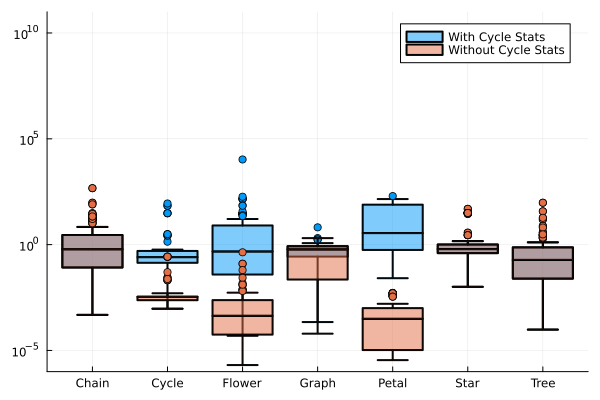

In [31]:
StatsPlots.boxplot(aids_query_types, [x[2] for x in aids_relative_errors_with_stats],  yscale=:log10, fillalpha=0.5, linewidth=2, label="With Cycle Stats", ylims=[10^-6, 10^11], yticks=[10^-5, 1, 10^5, 10^10])
StatsPlots.boxplot!(aids_query_types, [x[2] for x in aids_relative_errors],  yscale=:log10, fillalpha=0.5, linewidth=2, label="Without Cycle Stats")

In [63]:
print(data[!,"QueryType"])

Any["Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain

lower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "G

In [ ]:
lubm80_query_paths = ["lubm80/lubm80_Q2.txt",
# "lubm80/lubm80_Q4.txt",
# "lubm80/lubm80_Q7.txt",
# "lubm80/lubm80_Q8.txt",
# "lubm80/lubm80_Q9.txt",
# "lubm80/lubm80_Q12.txt"
                    ]
exactSizes = []
bounds = []
relativeErrors = []
println("Summary Size: ", summary_size[1])
println("Summary Build Time: ", build_time[1])
for query_path in lubm80_query_paths
    println("Query: ", query_path)
    id_and_query = load_query("queryset/" * query_path)
    id = id_and_query[1]
    query = id_and_query[2]
    bound_results = @timed get_cardinality_bounds(query, color_summaries[1])
    exact_size_results = @timed get_exact_size(query, datasets[1])
    gcare_size = load_true_cardinality("TrueCardinalities/" * query_path)
    println("Bound Time: ", bound_results[2])
    println("Exact Size Time: ", exact_size_results[2])
    println("Exact Size: ", exact_size_results[1])
    println("GCare Exact Size: ", gcare_size)
    if gcare_size != exact_size_results[1]
        println("Bad Exact Size Estimate!!")
        break
    end
    println("Bound [Lower, Avg, Upper]: ", bound_results[1])
    println("Relative Error [Lower, Avg, Upper]: ", (bound_results[1])./exact_size_results[1])
    push!(exactSizes, gcare_size)
    push!(bounds, bound_results[1])
    push!(relativeErrors, bound_results[1] ./ gcare_size)
end

In [ ]:
exactSizes